# Flipping-Performance

**Motviation:** The beginning of my QT was to investigate changes to the RNN so that it would be easier to calibrate it by flipping.

I switched out the $|s_{d0}|$ sort with an $s_{d0}$ sort for the tracks, and the flipping performance was slightly better for the $s_{d0}$ sort, so we decided to go with that.

One of the purposes of DIPS is to have an IP based tagger that doesn't rely on an arbitrary ordering for the tracks. However, we don't want to develop a new tagger that is *impossible* to calibrate, so I'm going to spend some time understanding how the different configurations of the LSTM and DIPS compare and perform.



In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import * #myLSTM, myPFN
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
tag = '_flip_noRev'

## Step 1: Load in the data for the *nominal* and *flipped* configurations

In [3]:
subDir = 'mc16d_PFlow_ttbar_ip3d'
dataDir = '../../data/' + subDir
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
# The pfn model 
dataTagTrain = "3mtrain_15trks_{}".format(vStr)
dataTagTest  = "2mtest_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
f = h5py.File(f_name,"r")

X = f['X_test'][:]
y = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

jet_df = pd.read_hdf('{}/jet_3mtest_15trks.h5'.format(dataDir), key='jet_df')

assert len(jet_df.index) == X.shape[0]

In [4]:
X_flip = X.copy()

if 'flip' in tag: 
    X_flip[:,:,:2] *= -1
    if tag == '_flip':
        X_flip = X_flip[:,::-1]
else:
    # For the negative version of the tagger, ONLY use the tracks with negative sd0
    pos_d0s = (X_flip[:,:,0] > 0)
    X_flip[pos_d0s] = 0
    

Plot the $s_{d0}$s for this configuration.

In [5]:
modelDir = '../../models/'+subDir
figDir = '../../figures/'

_, nTrks, nFeatures = X.shape

In [6]:
mask = getTrkMask(X_flip)

for yi,(c,f) in enumerate(zip(['C0','C1','C2'],['l','c','b'])):
    plt.hist(X_flip[:,:,0][(y==yi).reshape(-1,1) & mask], 
             50,(-20,20),histtype='step',
             color=c,label=f+'-jets',
             log=True,density=True)

if tag == "_neg":
    plt.ylim(2e-4,1)
    
plt.xlabel('$s_{d0}$', fontsize=16)
plt.ylabel('"Normalized" Entries', fontsize=14)
plt.legend(fontsize=16)
plt.savefig('{}/{}/sd0{}.pdf'.format(figDir,subDir,tag))
plt.show()


If I'm running in the negative tagger mode, I think it's good to compare the number of tracks that I have for b, c, and l-jets.

In [7]:
if tag == '_neg':
    
    nTrks_nom = np.sum(~ np.all(X == 0, axis=-1),axis=1)
    nTrks_flip = np.sum(~ np.all(X_flip == 0, axis=-1),axis=1)

    for yi,(c,f) in enumerate(zip(['C0','C1','C2'],['l','c','b'])):
        plt.hist(nTrks_nom[y==yi], 16,(-0.5,15.5),histtype='step',
                 color=c,label=f+'-jets: nominal',density=True)
        plt.hist(nTrks_flip[y==yi],16,(-0.5,15.5),histtype='step',linestyle='--',
                 color=c,label=f+'-jets: negative',density=True)
    
        nom = np.mean(nTrks_nom[y==yi])
        neg = np.mean(nTrks_flip[y==yi])
        print("<# tracks in {}-jets>: nominal = {}, negative = {}".format(f,nom,neg))
    
    plt.xlabel('$n_{trks}$', fontsize=14)
    plt.ylabel('"Normalized" Entries', fontsize=14)
    plt.legend(fontsize=10)
    plt.savefig('{}/{}/nTrks{}.pdf'.format(figDir,subDir,tag))
    plt.show()

In [8]:
dense_sizes = [100] * 3
ppm_sizes = [100,100,128]

In [9]:
lstm = myLSTM(modelDir=modelDir, nFeatures=nFeatures, 
            dataTag=dataTagTrain+'_sd0_rev', 
            nHidden=100,loadModel=True,nClasses=3)

dips_bn = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
            modelDir=modelDir, dataTag=dataTagTrain, nClasses=3, loadModel=True, 
            dropout=0,batch_norm=True)

dips_attn = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
            modelDir=modelDir, dataTag=dataTagTrain, nClasses=3, loadModel=True, 
            dropout=0,batch_norm=True,attn=True)


Initialize method from myModel()
Loading previously trained LSTM
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_ip3d/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_ip3d/DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file


## Step 2: Overlay the discriminants for each flavor for each of the configurations

In [69]:
figDir

'../../figures/'

In [10]:
rnn_colors = ['C0','C1','C2']
dips_colors = ['C6','C9','C4']
xlabel = '$D_b = \ln [ p_b / (f_c p_c + (1- f_c)p_l ) ]$'

../../models/mc16d_PFlow_ttbar_ip3d/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_flip_noRev.json
min: -7.03, max: 8.57


i_eff = 125, teff = 0.84830304225122
Cut on discriminant at 0.18714508533477758
i_eff = 111, teff = 0.767899800545968
Cut on discriminant at 1.5634495162963873
i_eff = 102, teff = 0.7030745759159703
Cut on discriminant at 2.4482166504859926
i_eff = 90, teff = 0.6002518484575616
Cut on discriminant at 3.6279061627387996


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
../../plottingFcts.py:529: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot((bins[:-1]+bins[1:])/2, n/nFirst, color=kargs['color'] )
../../plottingFcts.py:529: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot((bins[:-1]+bins[1:])/2, n/nFirst, color=kargs['color'] )


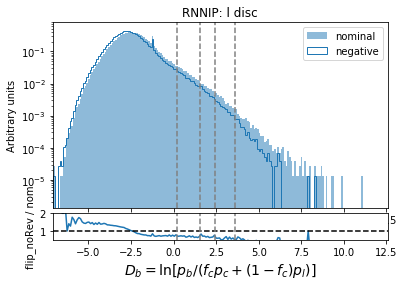

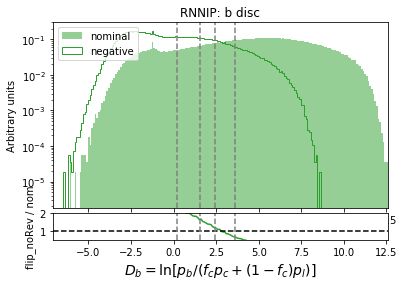

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_flip_noRev.json
min: -12.14, max: 9.97


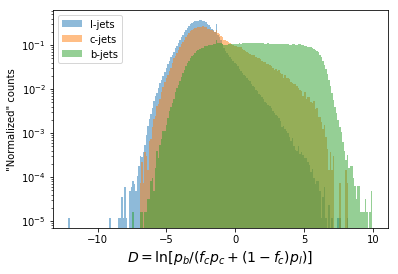

i_eff = 108, teff = 0.8478146196431138
Cut on discriminant at 0.2369736385345469
i_eff = 98, teff = 0.7682194953440002
Cut on discriminant at 1.6221147251129153
i_eff = 91, teff = 0.6999060452510224
Cut on discriminant at 2.591713485717774
i_eff = 83, teff = 0.6047240234655981
Cut on discriminant at 3.6998263549804697


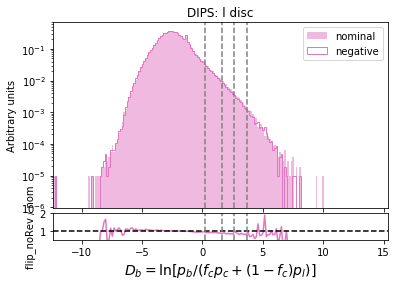

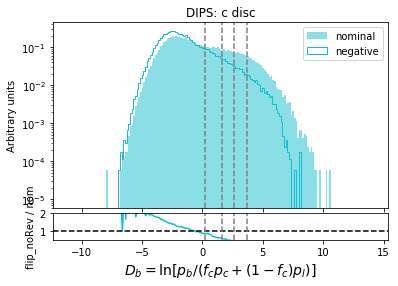

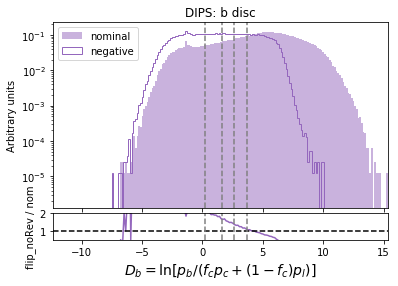

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_flip_noRev.json
min: -6.63, max: 9.90


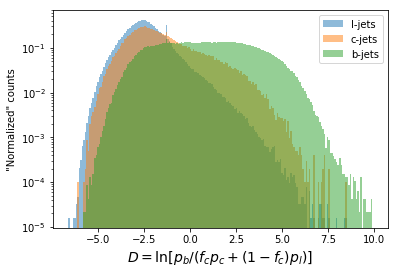

i_eff = 127, teff = 0.8522779142400946
Cut on discriminant at 0.1738759231567384
i_eff = 113, teff = 0.7693970378500883
Cut on discriminant at 1.6772375679016118
i_eff = 104, teff = 0.699762182591908
Cut on discriminant at 2.6436843395233165
i_eff = 94, teff = 0.603390185724917
Cut on discriminant at 3.717514085769654


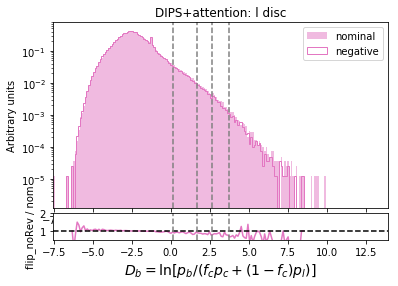

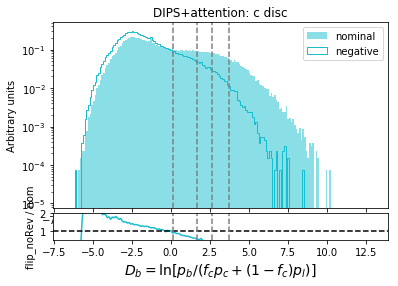

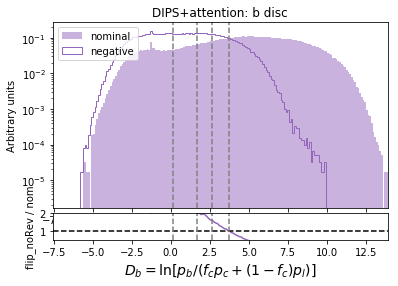

In [11]:
beffs, ceffs, leffs = [], [], []

for m, name, colors, model_tag in zip([lstm,dips_bn,dips_attn],['RNNIP','DIPS','DIPS+attention'],
                                   [rnn_colors,dips_colors,dips_colors],['rnn','dips','dips_bn_attn']):
    
    # Get the effs for the nominal configuation
    (l,c,b), d = getEffs(m, X, y, ix, returnDisc=True, figDir=figDir, subDir=subDir, modelDir=modelDir)
    
    # Get the effs for the flipped configuration
    (l_flip,c_flip,b_flip), d_flip = getEffs(m, X_flip, y, ix, returnDisc=True, figDir=figDir, 
                                               subDir=subDir, modelDir=modelDir,tag=tag)
     
    leffs += [l, l_flip]
    ceffs += [c, c_flip]
    beffs += [b, b_flip]
        
    discMax = np.max(np.concatenate((d,d_flip)))
    discMin = np.min(np.concatenate((d,d_flip)))
    myRange=(discMin,discMax) 
    nBins = 200
    
    cuts = []
    for WP in [85,77,70,60]:

        cut = workingPoint(d[y==2], nBins, myRange, WP=.01*WP)
        cuts.append(cut)
    
    for yi, flavor, c in zip([0,1,2], ['l','c','b'], colors):

        hist_arr  = [d[y == yi], d_flip[y == yi]]
        kargs_arr = [{'alpha':0.5,       'color':c, 'label':'nominal'}, 
                     {'histtype':'step', 'color':c, 
                      'label':'flipped' if tag=='_flip' else 'negative'}]

        rlabel = tag[1:] + ' / nom'
        
        dtag = flavor+"_disc_"+model_tag+tag
        plotRatio(hist_arr, kargs_arr, 
                  xrange=myRange, nBins=nBins,rrange=(0.5,2),
                  xlabel=xlabel, rlabel=rlabel, title=(name+': '+flavor+' disc'),
                  tag=dtag, figDir=figDir, subDir=subDir, cuts=cuts)



In [72]:
subDir

'mc16d_PFlow_ttbar_ip3d'

## Step 3: Look at the $p_T$ performance

**Goal:** At the workshop, Andy said that it was awesome that DIPS leaves the l-discriminant closer to unchanged, because a smaller $K_{LL} = \epsilon_l / \epsilon_l^{flip}$ will bring to smaller extrapolation uncertainties. 

However, to be able to extract the flavor fractions with a flavor sensitive observable (such as the secondary vertex mass), we need to not be overwhelmed by HF composition in the tight (60%) WP. Bing suggested that I look at recreating Table 2 from [l-jet mistag paper](https://cds.cern.ch/record/2314418) to see the flavor composition of the flipped tagger in bins of $p_T$.

<img src="../../figures/l-mistag_Table2.png" width="600">


In [73]:
subDir

'mc16d_PFlow_ttbar_ip3d'

In [74]:
pt = jet_df.pt
eta = jet_df.eta

In [75]:
524296 / 575625

0.910829098805646

In [76]:
266390 / 302369

0.8810096273096779

In [77]:
table = makeTable2(lstm, X, X_flip, y, jet_df.pt, jet_df.eta, WPs=[85,60], tag=tag)
print('RNNIP: HF fraction')
table.round(2)

../../models/mc16d_PFlow_ttbar_ip3d/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_neg.json
Load in the previously saved efficiency file
i_eff = 125, teff = 0.84830304225122
Cut on discriminant at 0.18714508533477758
85 0.18714508533477758
nominal 575625
flipped 59468
nominal HF 524296
flipped HF 49136
i_eff = 90, teff = 0.6002518484575616
Cut on discriminant at 3.6279061627387996
60 3.6279061627387996
nominal 351057
flipped 1845
nominal HF 348084
flipped HF 1804
RNNIP: HF fraction


20 GeV < $p_T^{jet}$ < 60 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                 0.87   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.84   
negative 85% WP $|\eta^{jet}|$ < 1.2                                 0.74   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.70   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                 0.99   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.98   
negative 60% WP $|\eta^{jet}|$ < 1.2                                 0.97   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.95   

                                            60 GeV < $p_T^{jet}$ < 100 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                  0.96   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.95   
negative 85% WP $|\eta^{jet}|$ < 1.2                                  0.90   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.87   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                  1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.99   
negative 60% WP $|\eta^{jet}|$ < 1.2                                  0.98   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.98   

                                            100 GeV < $p_T^{jet}$ < 200 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                   0.97   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.96   
negative 85% WP $|\eta^{jet}|$ < 1.2                                   0.94   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.91   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                   1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                             1.00   
negative 60% WP $|\eta^{jet}|$ < 1.2                                   0.99   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.98   

                                            200 GeV < $p_T^{jet}$ < 300 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                   0.96   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.92   
negative 85% WP $|\eta^{jet}|$ < 1.2                                   0.93   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.87   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                   1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.99   
negative 60% WP $|\eta^{jet}|$ < 1.2                                   0.98   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.97   

                                            300 GeV < $p_T^{jet}$ < 500 GeV  
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                   0.92  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.82  
negative 85% WP $|\eta^{jet}|$ < 1.2                                   0.92  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.77  
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                   0.99  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.97  
negative 60% WP $|\eta^{jet}|$ < 1.2                                   1.00  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.90

In [78]:
table = makeTable2(dips_bn, X, X_flip, y, jet_df.pt, jet_df.eta, WPs=[85,60],tag=tag)
print('DIPS with batch normalization: HF fraction')
table.round(2)

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_neg.json
Load in the previously saved efficiency file
i_eff = 108, teff = 0.8478146196431138
Cut on discriminant at 0.2369736385345469
85 0.2369736385345469
nominal 571138
flipped 54183
nominal HF 523162
flipped HF 45801
i_eff = 83, teff = 0.6047240234655981
Cut on discriminant at 3.6998263549804697
60 3.6998263549804697
nominal 354154
flipped 1004
nominal HF 350976
flipped HF 958
DIPS with batch normalization: HF fraction


20 GeV < $p_T^{jet}$ < 60 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                 0.88   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.85   
negative 85% WP $|\eta^{jet}|$ < 1.2                                 0.77   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.72   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                 0.98   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.98   
negative 60% WP $|\eta^{jet}|$ < 1.2                                 0.89   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.89   

                                            60 GeV < $p_T^{jet}$ < 100 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                  0.96   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.95   
negative 85% WP $|\eta^{jet}|$ < 1.2                                  0.91   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.89   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                  1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.99   
negative 60% WP $|\eta^{jet}|$ < 1.2                                  0.96   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.97   

                                            100 GeV < $p_T^{jet}$ < 200 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                   0.97   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.96   
negative 85% WP $|\eta^{jet}|$ < 1.2                                   0.95   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.92   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                   1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                             1.00   
negative 60% WP $|\eta^{jet}|$ < 1.2                                   0.99   
                1.2 < $|\eta^{jet}|$ < 2.5                             1.00   

                                            200 GeV < $p_T^{jet}$ < 300 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                   0.96   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.93   
negative 85% WP $|\eta^{jet}|$ < 1.2                                   0.94   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.86   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                   1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.99   
negative 60% WP $|\eta^{jet}|$ < 1.2                                   0.99   
                1.2 < $|\eta^{jet}|$ < 2.5                             1.00   

                                            300 GeV < $p_T^{jet}$ < 500 GeV  
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                   0.93  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.85  
negative 85% WP $|\eta^{jet}|$ < 1.2                                   0.91  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.77  
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                   1.00  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.99  
negative 60% WP $|\eta^{jet}|$ < 1.2                                   1.00  
                1.2 < $|\eta^{jet}|$ < 2.5                             1.00

Unless I have a bug, my take away message here is that our flipping this way is pretty sub-optimal, right?

In [79]:
table = makeTable2(dips_attn, X, X_flip, y, jet_df.pt, jet_df.eta, WPs=[85,60],tag=tag)
print('DIPS with batch normalization+attention: HF fraction')
table.round(2)

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_neg.json
Load in the previously saved efficiency file
i_eff = 127, teff = 0.8522779142400946
Cut on discriminant at 0.1738759231567384
85 0.1738759231567384
nominal 578960
flipped 57615
nominal HF 526764
flipped HF 48195
i_eff = 94, teff = 0.603390185724917
Cut on discriminant at 3.717514085769654
60 3.717514085769654
nominal 352480
flipped 1441
nominal HF 349660
flipped HF 1342
DIPS with batch normalization+attention: HF fraction


20 GeV < $p_T^{jet}$ < 60 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                 0.87   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.84   
negative 85% WP $|\eta^{jet}|$ < 1.2                                 0.76   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.71   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                 0.99   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.99   
negative 60% WP $|\eta^{jet}|$ < 1.2                                 0.83   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.83   

                                            60 GeV < $p_T^{jet}$ < 100 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                  0.96   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.95   
negative 85% WP $|\eta^{jet}|$ < 1.2                                  0.91   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.87   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                  1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                            1.00   
negative 60% WP $|\eta^{jet}|$ < 1.2                                  0.97   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.99   

                                            100 GeV < $p_T^{jet}$ < 200 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                   0.97   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.96   
negative 85% WP $|\eta^{jet}|$ < 1.2                                   0.94   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.91   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                   1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                             1.00   
negative 60% WP $|\eta^{jet}|$ < 1.2                                   0.99   
                1.2 < $|\eta^{jet}|$ < 2.5                             1.00   

                                            200 GeV < $p_T^{jet}$ < 300 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                   0.96   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.91   
negative 85% WP $|\eta^{jet}|$ < 1.2                                   0.92   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.83   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                   1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.99   
negative 60% WP $|\eta^{jet}|$ < 1.2                                   1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                             1.00   

                                            300 GeV < $p_T^{jet}$ < 500 GeV  
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                   0.90  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.77  
negative 85% WP $|\eta^{jet}|$ < 1.2                                   0.80  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.65  
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                   0.99  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.97  
negative 60% WP $|\eta^{jet}|$ < 1.2                                   0.97  
                1.2 < $|\eta^{jet}|$ < 2.5                             1.00

**Note:** There may be other ways that I want to convey this info, but I think this is a good place to start from.

In [80]:
nom, flip = effPCBins(lstm, X, X_flip, y, tag=tag)
print('RNNIP: efficiency')
flip.round(3)

../../models/mc16d_PFlow_ttbar_ip3d/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_neg.json
Load in the previously saved efficiency file
i_eff = 125, teff = 0.84830304225122
Cut on discriminant at 0.18714508533477758
i_eff = 111, teff = 0.767899800545968
Cut on discriminant at 1.5634495162963873
i_eff = 102, teff = 0.7030745759159703
Cut on discriminant at 2.4482166504859926
i_eff = 90, teff = 0.6002518484575616
Cut on discriminant at 3.6279061627387996
RNNIP: efficiency


100%-85%  85%-77%  77%-70%  70%-60%   <60%
l-jets     0.992    0.007    0.001    0.000  0.000
c-jets     0.964    0.028    0.006    0.002  0.000
b-jets     0.921    0.052    0.017    0.007  0.003

In [81]:
# Just a sanity check - looks good!
nom.round(3)

100%-85%  85%-77%  77%-70%  70%-60%   <60%
l-jets     0.959    0.030    0.007    0.004  0.001
c-jets     0.618    0.137    0.078    0.084  0.083
b-jets     0.152    0.080    0.065    0.103  0.600

In [82]:
nom, flip = effPCBins(dips_bn, X, X_flip, y, tag=tag)
print('DIPS + batch norm: efficiency')
flip.round(3)

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_neg.json
Load in the previously saved efficiency file
i_eff = 108, teff = 0.8478146196431138
Cut on discriminant at 0.2369736385345469
i_eff = 98, teff = 0.7682194953440002
Cut on discriminant at 1.6221147251129153
i_eff = 91, teff = 0.6999060452510224
Cut on discriminant at 2.591713485717774
i_eff = 83, teff = 0.6047240234655981
Cut on discriminant at 3.6998263549804697
DIPS + batch norm: efficiency


100%-85%  85%-77%  77%-70%  70%-60%   <60%
l-jets     0.994    0.005    0.001    0.000  0.000
c-jets     0.968    0.025    0.006    0.001  0.000
b-jets     0.926    0.048    0.019    0.006  0.002

Also, could calculate the $K_{LL}^{MC}$ and $K_{HF}^{MC}$ factors from table 3 of the l mistag rate conf note.

$$K_{LL}^{MC} = \left( \frac{\epsilon_{LF}}{\epsilon_{LF,neg}} \right)^{MC}$$

$$K_{HF}^{MC} = \left( \frac{\epsilon_{LF,neg}}{\epsilon_{all,neg}} \right)^{MC}$$

However, I think I have enough metrics already to answer the questions that I have.

In [83]:
nom, flip = effPCBins(dips_attn, X, X_flip, y, tag=tag)
print('DIPS + batch norm + attention: efficiency')
flip.round(3)

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_neg.json
Load in the previously saved efficiency file
i_eff = 127, teff = 0.8522779142400946
Cut on discriminant at 0.1738759231567384
i_eff = 113, teff = 0.7693970378500883
Cut on discriminant at 1.6772375679016118
i_eff = 104, teff = 0.699762182591908
Cut on discriminant at 2.6436843395233165
i_eff = 94, teff = 0.603390185724917
Cut on discriminant at 3.717514085769654
DIPS + batch norm + attention: efficiency


100%-85%  85%-77%  77%-70%  70%-60%   <60%
l-jets     0.993    0.006    0.001    0.000  0.000
c-jets     0.966    0.026    0.006    0.002  0.000
b-jets     0.922    0.051    0.018    0.007  0.002

In [84]:
.124/.002

62.0

## Step 4: Efficiency curves

../../models/mc16d_PFlow_ttbar_ip3d/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_flip_noRev.json
Load in the previously saved efficiency file


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


i_eff = 125, teff = 0.84830304225122
Cut on discriminant at 0.18714508533477758
i_eff = 111, teff = 0.767899800545968
Cut on discriminant at 1.5634495162963873
i_eff = 102, teff = 0.7030745759159703
Cut on discriminant at 2.4482166504859926
i_eff = 90, teff = 0.6002518484575616
Cut on discriminant at 3.6279061627387996


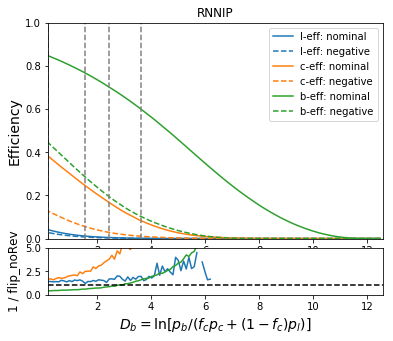

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_flip_noRev.json
Load in the previously saved efficiency file
i_eff = 108, teff = 0.8478146196431138
Cut on discriminant at 0.2369736385345469
i_eff = 98, teff = 0.7682194953440002
Cut on discriminant at 1.6221147251129153
i_eff = 91, teff = 0.6999060452510224
Cut on discriminant at 2.591713485717774
i_eff = 83, teff = 0.6047240234655981
Cut on discriminant at 3.6998263549804697


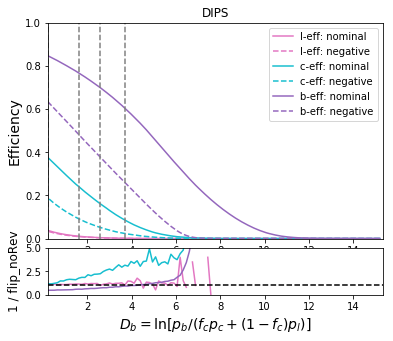

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_flip_noRev.json
Load in the previously saved efficiency file
i_eff = 127, teff = 0.8522779142400946
Cut on discriminant at 0.1738759231567384
i_eff = 113, teff = 0.7693970378500883
Cut on discriminant at 1.6772375679016118
i_eff = 104, teff = 0.699762182591908
Cut on discriminant at 2.6436843395233165
i_eff = 94, teff = 0.603390185724917
Cut on discriminant at 3.717514085769654


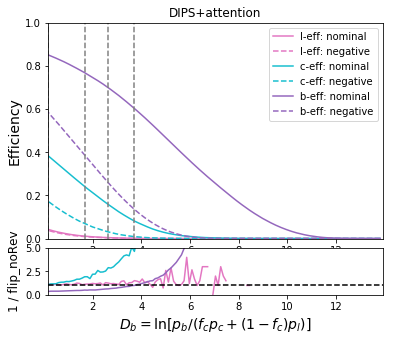

In [12]:
for m,name,colors,model_tag in zip([lstm,dips_bn,dips_attn],['RNNIP','DIPS','DIPS+attention'],
                                   [rnn_colors,dips_colors,dips_colors],['rnn','dips','dips_attn']):
    
    # Get the effs for the nominal configuation
    (_, _, _), d = getEffs(m, X, y, ix, returnDisc=True, figDir=figDir, subDir=subDir, modelDir=modelDir)
    
    # Get the effs for the flipped configuration
    (_, _, _), d_flip = getEffs(m, X_flip, y, ix, returnDisc=True, figDir=figDir, 
                                subDir=subDir, modelDir=modelDir,tag=tag)
             
    discMax = np.max(np.concatenate((d,d_flip)))
    discMin = np.min(np.concatenate((d,d_flip)))
    myRange= (discMin,discMax)#(np.min(d),np.max(d)) 
    nBins = 200

    fig = plt.figure(0,figsize=(6,5))
    gs = gridspec.GridSpec(5,1)
    ax1 = fig.add_subplot(gs[:4,0])
    ax2 = fig.add_subplot(gs[4:,0])
    
    for yi, flavor, c in zip([0,1,2], ['l','c','b'], colors):

    
        # Overlay the effs on the same
        n, edg      = np.histogram(d[y == yi], nBins, myRange, density=True)
        n_flip, edg = np.histogram(d_flip[y == yi], nBins, myRange, density=True)
        
        
        ax1.plot(edg[:-1][::-1],calculateEff(n), color=c,
                 label=flavor+'-eff: nominal')
        ax1.plot(edg[:-1][::-1],calculateEff(n_flip), color=c, linestyle='--',
                 label=flavor+'-eff: '+ ('flipped' if tag=='_flip' else 'negative'))
        ax2.plot(edg[:-1], n / n_flip, color=c)
        
    # It would be super cool to put the pseudo continuous btagging bins on the x-axis
    cuts = []
    for WP in [85,77,70,60]:

        cut = workingPoint(d[y==2], nBins, myRange, WP=.01*WP)
        cuts.append(cut)
    
        ax1.plot([cut]*2,[0,1],'grey',linestyle='--')
    
    ax1.set_xlim([cuts[0],discMax])
    ax1.set_ylim(0,1)
    
    ax2.plot([cuts[0],discMax],[1]*2,'k--')
    ax2.set_xlim([cuts[0],discMax])
    ax2.set_ylim(0,5)
    
    ax1.legend()
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Efficiency',fontsize=14)
    ax1.set_title(name)
    
    ax2.set_xlabel(xlabel,fontsize=14)
    ax2.set_ylabel('1 / {}'.format(tag.strip("_")),fontsize=12)
    
    plt.savefig('{}/{}/varyEff_{}{}.pdf'.format(figDir, subDir, model_tag, tag))
    
    plt.show()
    #break

In [13]:
edg

array([-7.55769825, -7.45031528, -7.3429323 , -7.23554933, -7.12816635,
       -7.02078338, -6.9134004 , -6.80601743, -6.69863445, -6.59125148,
       -6.4838685 , -6.37648553, -6.26910255, -6.16171958, -6.05433661,
       -5.94695363, -5.83957066, -5.73218768, -5.62480471, -5.51742173,
       -5.41003876, -5.30265578, -5.19527281, -5.08788983, -4.98050686,
       -4.87312388, -4.76574091, -4.65835793, -4.55097496, -4.44359199,
       -4.33620901, -4.22882604, -4.12144306, -4.01406009, -3.90667711,
       -3.79929414, -3.69191116, -3.58452819, -3.47714521, -3.36976224,
       -3.26237926, -3.15499629, -3.04761332, -2.94023034, -2.83284737,
       -2.72546439, -2.61808142, -2.51069844, -2.40331547, -2.29593249,
       -2.18854952, -2.08116654, -1.97378357, -1.86640059, -1.75901762,
       -1.65163465, -1.54425167, -1.4368687 , -1.32948572, -1.22210275,
       -1.11471977, -1.0073368 , -0.89995382, -0.79257085, -0.68518787,
       -0.5778049 , -0.47042192, -0.36303895, -0.25565598, -0.14

## Step 5: Compare the flipped vs nominal configurations

../../plottingFcts.py:632: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


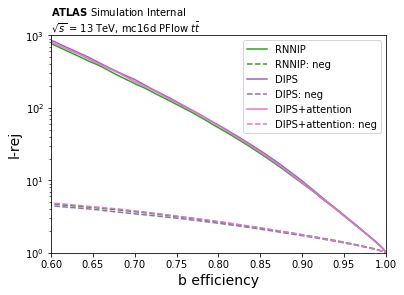

In [86]:
# colors = ['C2','C4','C6']*2
# styles = ['-']*3 + ['--']*3

colors = ['C2']*2 + ['C4']*2 + ['C6']*2
styles = ['-','--']*3

labels = ['{}{}'.format(model,config) for model in ['RNNIP','DIPS','DIPS+attention'] for config in ['',': {}'.format(tag.strip("_"))]]

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, mc16d PFlow $t\bar{t}$"

plotROC(beffs, leffs, labels,text=text,
        ylabel='l-rej',styles=styles,colors=colors,
        figDir=figDir,subDir=subDir,tag='lrej_attn'+tag)
plotROC(beffs, ceffs, labels,text=text,
        ylabel='c-rej',styles=styles,colors=colors,ymax=100,
        figDir=figDir,subDir=subDir,tag='crej_attn'+tag)